# Optimizing workflows
In this notebook we demonstrate how to setup a workflow and optimize its parameters with a given sparse annotation.

See also:
* [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
* [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [1]:
from skimage.io import imread
from scipy.optimize import minimize
import numpy as np
import pyclesperanto as cle

We start with loading an example image and a manual annotation. Not all objects must be annotated (sparse annotation).

array([[ 40.,  32.,  24., ..., 216., 200., 200.],
       [ 56.,  40.,  24., ..., 232., 216., 216.],
       [ 64.,  48.,  24., ..., 240., 232., 232.],
       ...,
       [ 72.,  80.,  80., ...,  48.,  48.,  48.],
       [ 80.,  80.,  80., ...,  48.,  48.,  48.],
       [ 96.,  88.,  80., ...,  48.,  48.,  48.]],
      shape=(254, 256), dtype=float32, mtype=buffer)
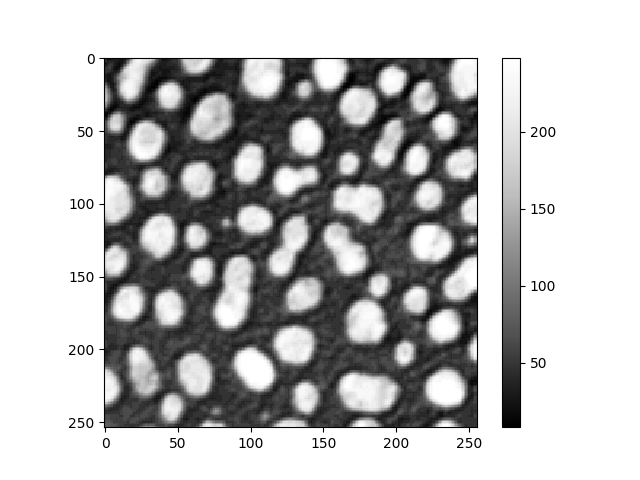
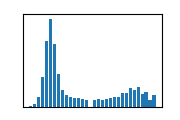

In [2]:
blobs = cle.push(imread('https://samples.fiji.sc/blobs.png').squeeze().astype(float))
blobs

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(254, 256), dtype=int32, mtype=buffer)
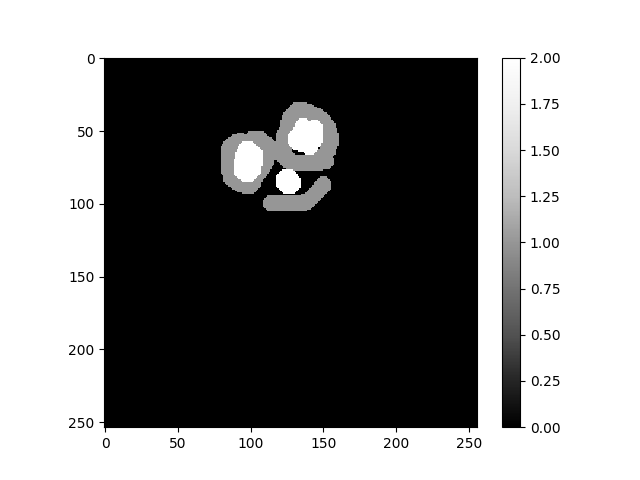
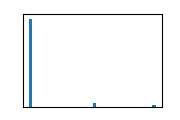

In [3]:
annotation = cle.push(imread('https://github.com/clEsperanto/pyclesperanto_prototype/raw/master/data/blobs_annotated.tif'))
annotation

Next, we define an image processing workflow that results in a binary image.

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(254, 256), dtype=uint8, mtype=buffer)
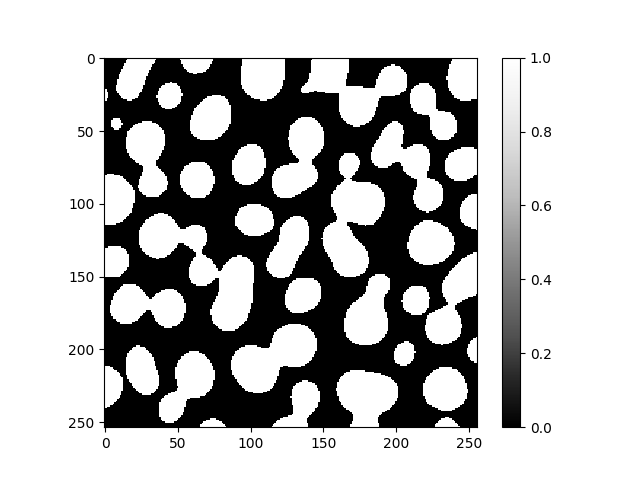
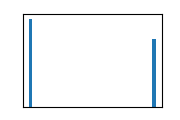

In [4]:
def my_workflow(image, sigma, threshold):
    blurred = cle.gaussian_blur(image, sigma_x=sigma, sigma_y=sigma)
    binary = cle.greater_constant(blurred, scalar=threshold)
    return binary
  
# Test the workflow with more or less random parameters
test = my_workflow(blobs, 5, 100)
test

Our workflow, with our first parameter tested, does not segment well. We can know this by eye, but we can also define a [fitness function](https://en.wikipedia.org/wiki/Fitness_function) to evaluate it.

Our takes two parameters: A given segmentation result (test) and a reference annotation. It then determines how good the segmentation is, e.g. using the Jaccard index.

In [5]:
def fitness(test, reference):
    """
    Determine how correct a given test segmentation is. 
    As metric we use the Jaccard index.
    Assumtion: test is a binary image(0=False and 1=True) and 
    reference is an image with 0=unknown, 1=False, 2=True.
    """
    negative_reference = reference == 1
    positive_reference = reference == 2
    negative_test = test == 0
    positive_test = test == 1
    # true positive: test = 1, ref = 2
    tp = cle.binary_and(positive_reference, positive_test).sum()
    # true negative: 
    tn = cle.binary_and(negative_reference, negative_test).sum()
    # false positive
    fp = cle.binary_and(negative_reference, positive_test).sum()
    # false negative
    fn = cle.binary_and(positive_reference, negative_test).sum()
    # return Jaccard Index
    return tp / (tp + fn + fp)

fitness(test, annotation)

0.7425149700598802

We have now a workflow, and a fitness function that evaluate our workflow. We can start playing around with the parameter to search for a better segmentation score.

In [6]:
# test a couple of thresholds and print corresponding fitness
for t in range(70, 180, 10):
    test = my_workflow(blobs, 5, t)
    print(fitness(test, annotation))

0.4904862579281184
0.5843037974683545
0.6701940035273368
0.7425149700598802
0.8183873398643556
0.8378158109209454
0.790893760539629
0.7024013722126929
0.6060344827586207
0.4982758620689655
0.39741379310344827


The issue here is that we have two parameters, this can make the search for an optimal quite tedious by "hand". 

Instead we can use a minimization function fron `scipy` to search for in a parameter space for us and provide us with the optmimal set of parameter.

In [11]:
def fun(x):
    # apply current parameter setting
    test = my_workflow(blobs, x[0], x[1])
    # as we are minimizing, we multiply fitness with -1
    return -fitness(test, annotation)

# starting point in parameter space
x0 = np.array([5, 100])

# run the optimization
res = minimize(fun, x0, method='nelder-mead', options={'xatol': 1e-3, 'disp': True})

# print and show result
print(res)
print()
x = res['x']
print(f"final result, sigma={x[0]}, threshold={x[1]}")

Optimization terminated successfully.
         Current function value: -0.857613
         Iterations: 22
         Function evaluations: 65
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.8576131687242798
             x: [ 3.895e+00  1.219e+02]
           nit: 22
          nfev: 65
 final_simplex: (array([[ 3.895e+00,  1.219e+02],
                       [ 3.895e+00,  1.219e+02],
                       [ 3.895e+00,  1.219e+02]]), array([-8.576e-01, -8.576e-01, -8.576e-01]))

final result, sigma=3.89501953125, threshold=121.94091796875


We can use the result parameter set to run our workflow with better results

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(254, 256), dtype=uint8, mtype=buffer)
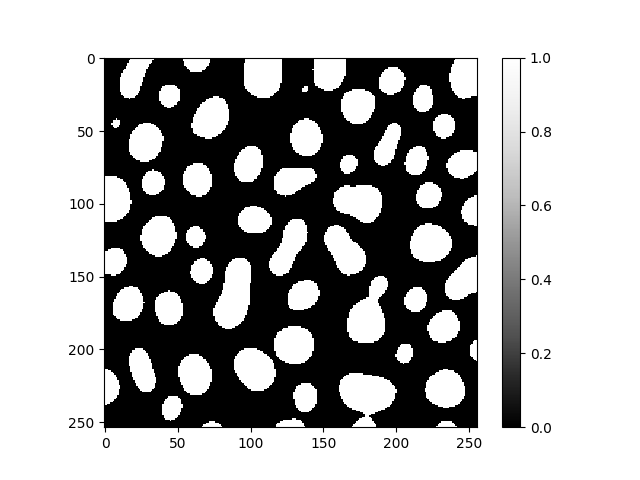
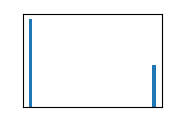

In [8]:
best_binary = my_workflow(blobs, x[0], x[1])
best_binary

This strategy can be used outside of pyclesperanto, with other libraries like scikit-image. It can, however, become a long search process that pyclesperanto GPU acceleration can make faster.

Enjoy!